In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Be careful for set path
cur_path1 = os.getcwd()

In [2]:
print(cur_path1)
#q_star_arr = [ "1700", "1800", "1900", "2000", "2100", "2200", "2300", "2400"]
# q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1550", "1600", "1700"]
q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1550", "1600", "1650", "1700", "1800", "1900", "2000", "2100", "2200", "2300", "2400"]
# q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1600", "1700", "1800" , "1900" ]
cur_path = cur_path1

C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling


In [3]:

#Get q values for each simulation and save it as numpy array. Data is a list collecting all numpy arrays.
q_arr = []

for i in q_star_arr:
    work_path = cur_path + "\\" +i
    print(work_path)
    os.chdir(work_path)
    
    file = 'TM_'+i+'_monitor.dat'
    q = np.array(pd.read_csv(file, sep='\t|  ',engine='python'))
    print(q.shape)
    
    if np.int(i) < 200:
        q_arr += [q[75000:,1]]
    else:
        q_arr += [q[25000:,1]]

q_arr = np.array(q_arr)

C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\100
(100001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\200
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\300
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\400
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\500
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\600
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\700
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\800
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\900
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\1000
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\1100
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\1200
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\1300
(50001, 7)
C:\Users\pcuser\Desktop\tutorial\AFP\Tm\sparse_sampling\1400
(50001, 7)


In [4]:
q_star_arr2 = np.array([np.int(q_star_arr[i]) for i in range(len(q_star_arr))])

In [5]:
# This code is writting by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import autograd.numpy as nup
from autograd import value_and_grad
from scipy.optimize import minimize
from autograd.extend import primitive
from scipy.special import logsumexp


class binwham:
    
    '''
    Calculates free energy using bin wham.
    Code is based on Zhu, Fangqiang, and Gerhard Hummer. Journal of computational chemistry 33.4 (2012): 453-465.
    
    Pil = fi*Cil*Pl
    
    Args:
      op_star_arr(numpy.ndarray): op* matrix (N,)
      op_arr(numpy.ndarray): op matrix (simulation #, time #)
      n_bins(int): The number of bins that the probability should bin
      kappa(float): harmonic bias spring constant in kJ/mol
    '''
    
    def __init__(self, op_star_arr, op_arr, kappa, n_bins=100, T=298):
        
        self.op_star_arr = op_star_arr
        self.op_arr = op_arr
        self.n_bins = n_bins
        self.kappa = kappa
        self.T = T
        self.beta = 1/8.314/T*1000
        self.M = n_bins
        
        
        #S: number of simulations
        self.S = len(self.op_star_arr)
        
        #M: number of bins
        self.M = n_bins
        
        #Ni: number of samples in each simulation
        self.Ni = np.array([len(self.op_arr[i]) for i in range(self.S)])
        
        #Ml: number of simulations in the bin - np.ndarray(n_bins,)
        min_ = np.min(self.op_arr)
        max_ = np.max(self.op_arr)

        self.bins_1 = np.linspace(min_, max_, self.M+1) #shape (M+1,)
        self.bins_ = self.bins_1[1:] #shape (M,)
        
        digitized = np.digitize(self.op_arr, self.bins_1, right = False)
        self.Ml = np.array([(digitized == i).sum() for i in range(1, self.M +1)])
        
        #Pil: probability for each simulation on each bins - np.ndarray(S,M)
        self.Pil = np.zeros((self.S, self.M))
        for i in range(self.S):
            digitized = np.digitize(self.op_arr[i], self.bins_1, right = False)
            count = np.array([(digitized == i).sum() for i in range(1, self.M+1)])
            self.Pil[i,:] = count/len(digitized)
            
        #Wil: bias potential energy - kappa/2*(xl-ri)^2 np.ndarray((S,M))
        self.Wil = np.zeros((self.S,self.M))
        for i in range(self.S):

            ri = self.op_star_arr[i]
            self.Wil[i,0] = self.beta*self.kappa/2*np.power(self.bins_[0] - ri,2)

            for l in range(1,self.M):
                middle = (self.bins_[l] + self.bins_[l-1])/2
                self.Wil[i,l] = self.beta*self.kappa/2*np.power(middle-ri,2)


        self.Cil = np.exp(-self.Wil)

        self.gi0 = np.zeros(self.S,) + 1e-8
        

    def optimize_fn(self, gi, Ni, Ml, Cil):
        
        first_term = - (Ni*gi).sum()
        log_pl = nup.log(Ml) - alogsumexp(nup.repeat(gi[:,nup.newaxis],self.M,axis=1)-self.Wil, axis=0, b=nup.repeat(Ni[:,nup.newaxis],self.M,axis=1))
        second_term = - (Ml*log_pl).sum(axis = 0)
        

        return first_term + second_term
    
    def MLE_optimize(self):
        

        result = minimize(value_and_grad(self.optimize_fn),self.gi0,args=(self.Ni,self.Ml,self.Cil),jac=True,method='L-BFGS-B')

        if result.success:
            gi = result.x
            log_pl = nup.log(self.Ml) - alogsumexp(nup.repeat(gi[:,nup.newaxis],self.M,axis=1)-self.Wil, axis=0, b=nup.repeat(self.Ni[:,nup.newaxis],self.M,axis=1))
            F = -log_pl
            F = F - np.min(F)
            
            figure(figsize=(8,6), dpi = 200)
            plt.plot(self.bins_,F)
            plt.xlabel(r'$q$', fontsize = 15)
            plt.ylabel(r'$\beta F(q)$', fontsize=15)
            
            return gi, log_pl, F
        
        else:
            print('fail to do minimization')
            
    def driving_force(self):
        _,_,F = self.MLE_optimize()
        
        df = np.zeros(len(F)-1,)
        for i in range(len(F)-1):
            df[i] = (F[i+1] - F[i])/(self.bins_[i+1] - self.bins_[i])
        
        figure(figsize=(8,6), dpi = 200)
        plt.plot(self.bins_[1:], df)
        plt.xlabel(r'$q$', fontsize = 15)
        plt.ylabel(r'$\beta \frac{\partial F}{\partial q}$', fontsize=15)
        
        return self.bins_[1:], df
    
def alogsumexp(a, axis=None, b=None):
    
    '''
    Calculates logsumexp using the autograd numpy
    np.log(np.sum(b*np.exp(a)))
    '''
    
    if b is not None:
        if nup.any(b ==0):
            a = a + 0.
            a[b == 0] = -nup.inf
    
    max_a = nup.amax(a,axis=axis,keepdims=True)

    if b is not None:
        b = nup.asarray(b)
        tmp = b*nup.exp(a - max_a)
    else:
        tmp = nup.exp(a-max_a)

    # Suppress warning about log zero
    with nup.errstate(divide='ignore'):
        s = nup.sum(tmp, axis=axis)
    
    out = nup.log(s)
    max_a = nup.squeeze(max_a, axis = axis)

    return max_a + out

In [114]:
cc = binwham(q_star_arr2, q_arr, 0.01, 100)

In [102]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def sanity_counts(binwham_object):
    '''
    
    Generate plot for sanity check in terms of count.
    
    Args:
      binwham_object(binwham object)
    '''
    
    a = cc.Ml
    figure(figsize=(8,6), dpi = 200)
    plt.xlabel(r'$bins$', fontsize = 15)
    plt.ylabel(r'$counts$', fontsize = 15)
    plt.plot(a)
    
    figure(figsize=(8,6), dpi = 200)
    plt.xlabel(r'$bins$', fontsize = 15)
    plt.ylabel(r'$counts$', fontsize = 15)
    plt.plot(a)
    plt.ylim(0,100)
    
def kl_divergence(binwham_object,kappa=0.01,T=298,cutoff=0.1):
    '''
    
    Calculate kl divergence for binwham for each window.
    
    Args:
      binwham_object(binwham object)
      kappa(np.float): spring constant in kJ/mol
      T(np.float): absolute temperature
      cutoff(np.float): cutoff value for kl divergence
    
    '''
    cc = binwham_object
    Pil = cc.Pil
    q_bins = cc.bins_
    _,_,F = cc.MLE_optimize()
    beta = 1/298/8.314*1000
    kldivergence = np.zeros(len(Pil),)

    for i in range(len(Pil)):

        Pil_i = cc.Pil[i]
        effective_Pil_i = Pil_i[np.nonzero(Pil_i)]
        # print(np.nonzero(Pil_i))

        effective_bins = q_bins[np.nonzero(Pil_i)]
        # print(effective_bins)

        effective_F = F[np.nonzero(Pil_i)]
        # print(effective_F)

        effective_U = 1/2*kappa*beta*(q_star_arr2[i]-effective_bins)**2
        # print(effective_U)


        max_ = np.max(effective_F + effective_U)
        exp_term = np.exp(-effective_F-effective_U+max_)

        effective_Q_i = exp_term/np.sum(exp_term)

        Pi = effective_Pil_i
        Qi = effective_Q_i

        kldivergence[i] = np.sum(Pi*np.log(Pi/Qi))
        
    counts_ = np.count_nonzero(kldivergence > cutoff)
    if counts_:
        print('there are ',counts_,'values that are over cutoff value',cutoff)
    else:
        print('Each KL divergence is less than cutoff value', cutoff)
    

    figure(figsize=(8,6), dpi=200)
    windoww = list(range(len(kldivergence)))

    plt.scatter(windoww, kldivergence, marker='o')

    plt.xlabel(r'$simulation\  window$', fontsize=15)
    plt.ylabel(r'$KL\  divergence$', fontsize=15)

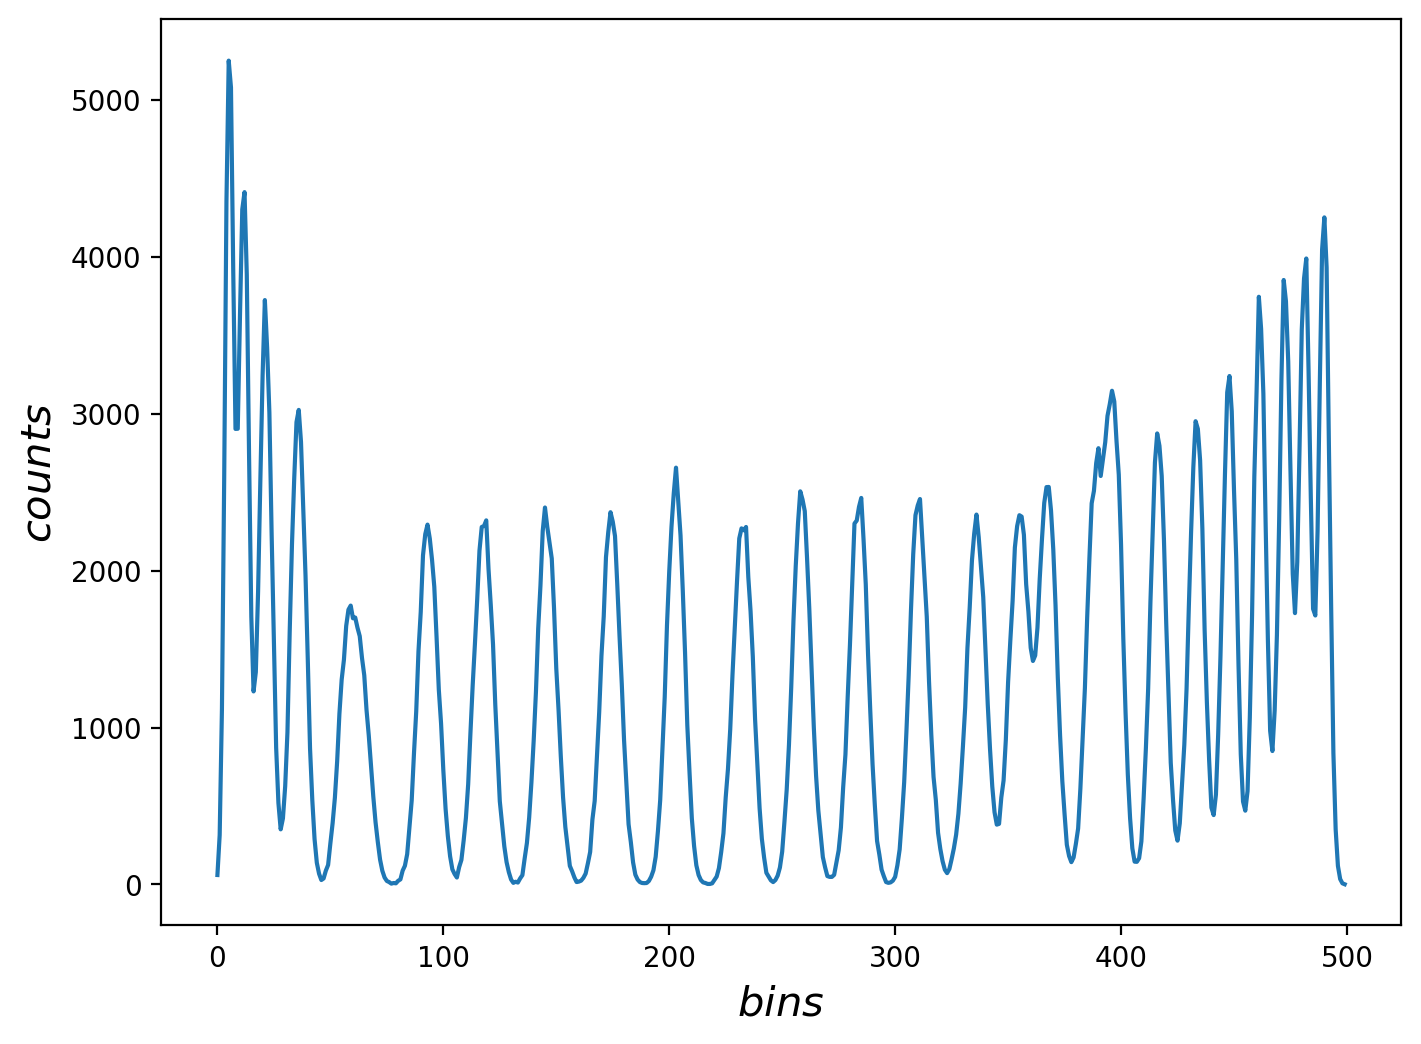

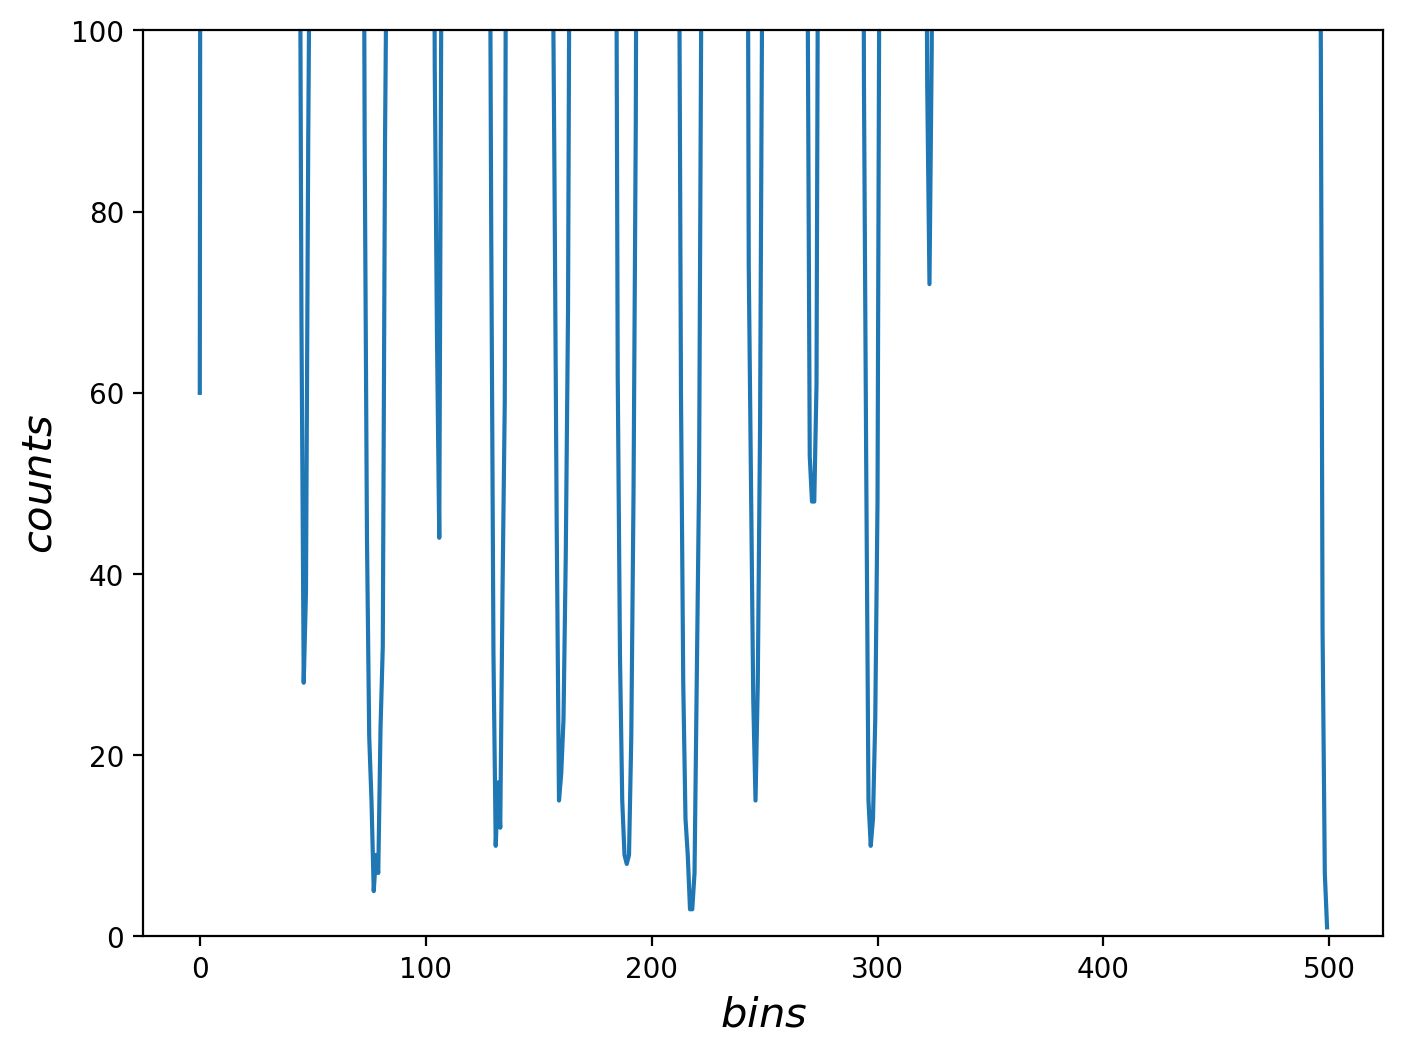

In [103]:
sanity_counts(cc)

Each KL divergence is less than cutoff value 0.1


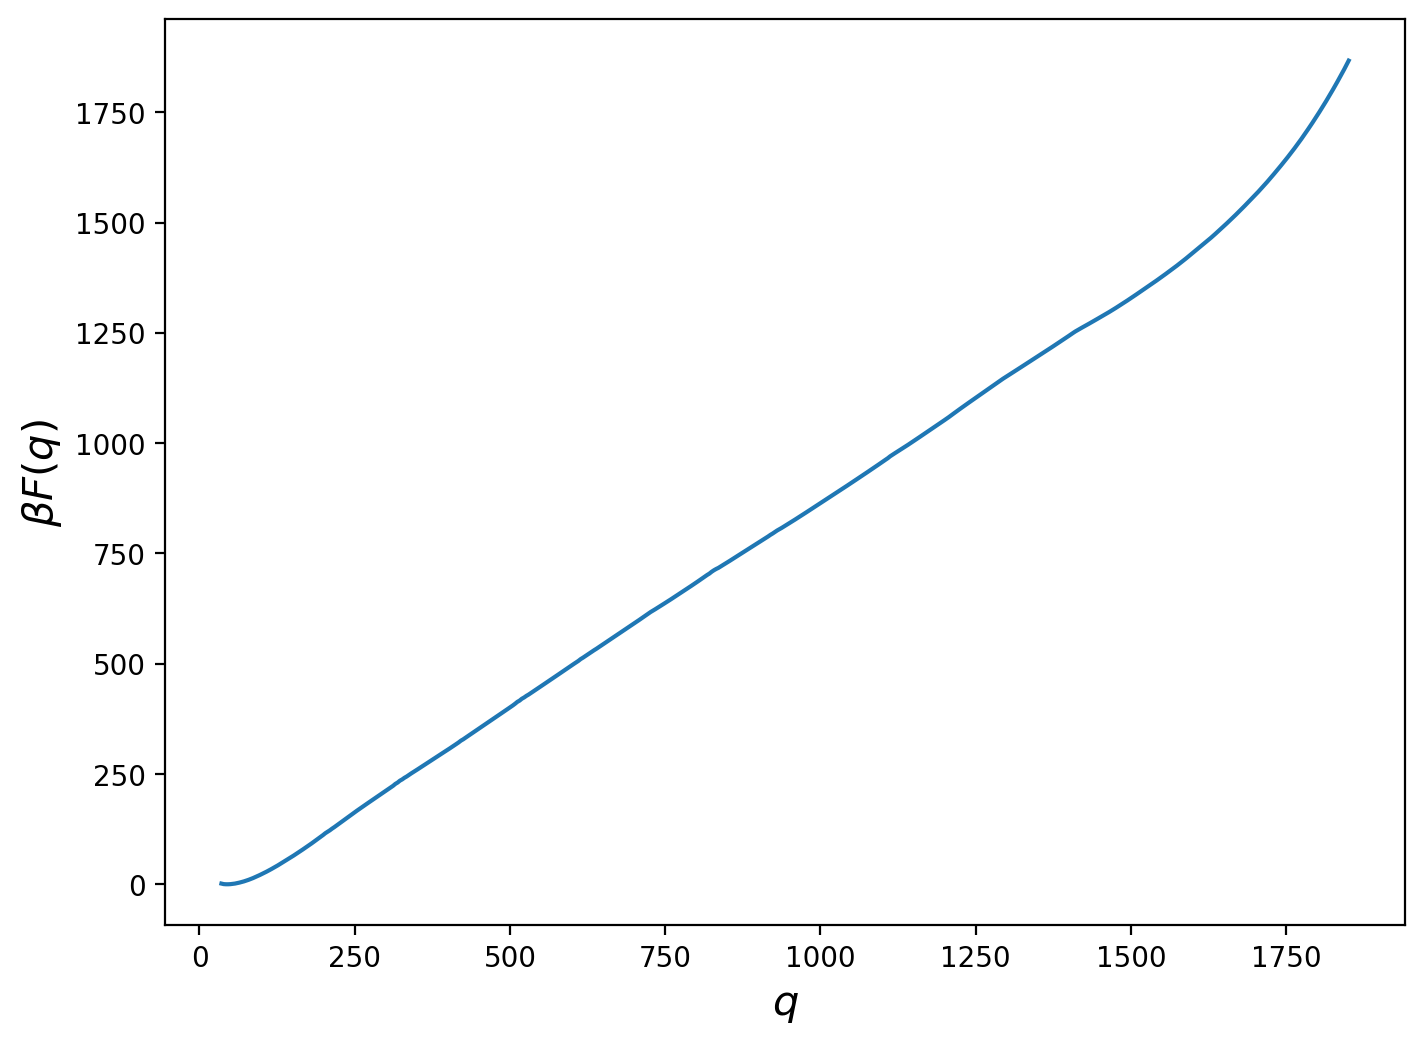

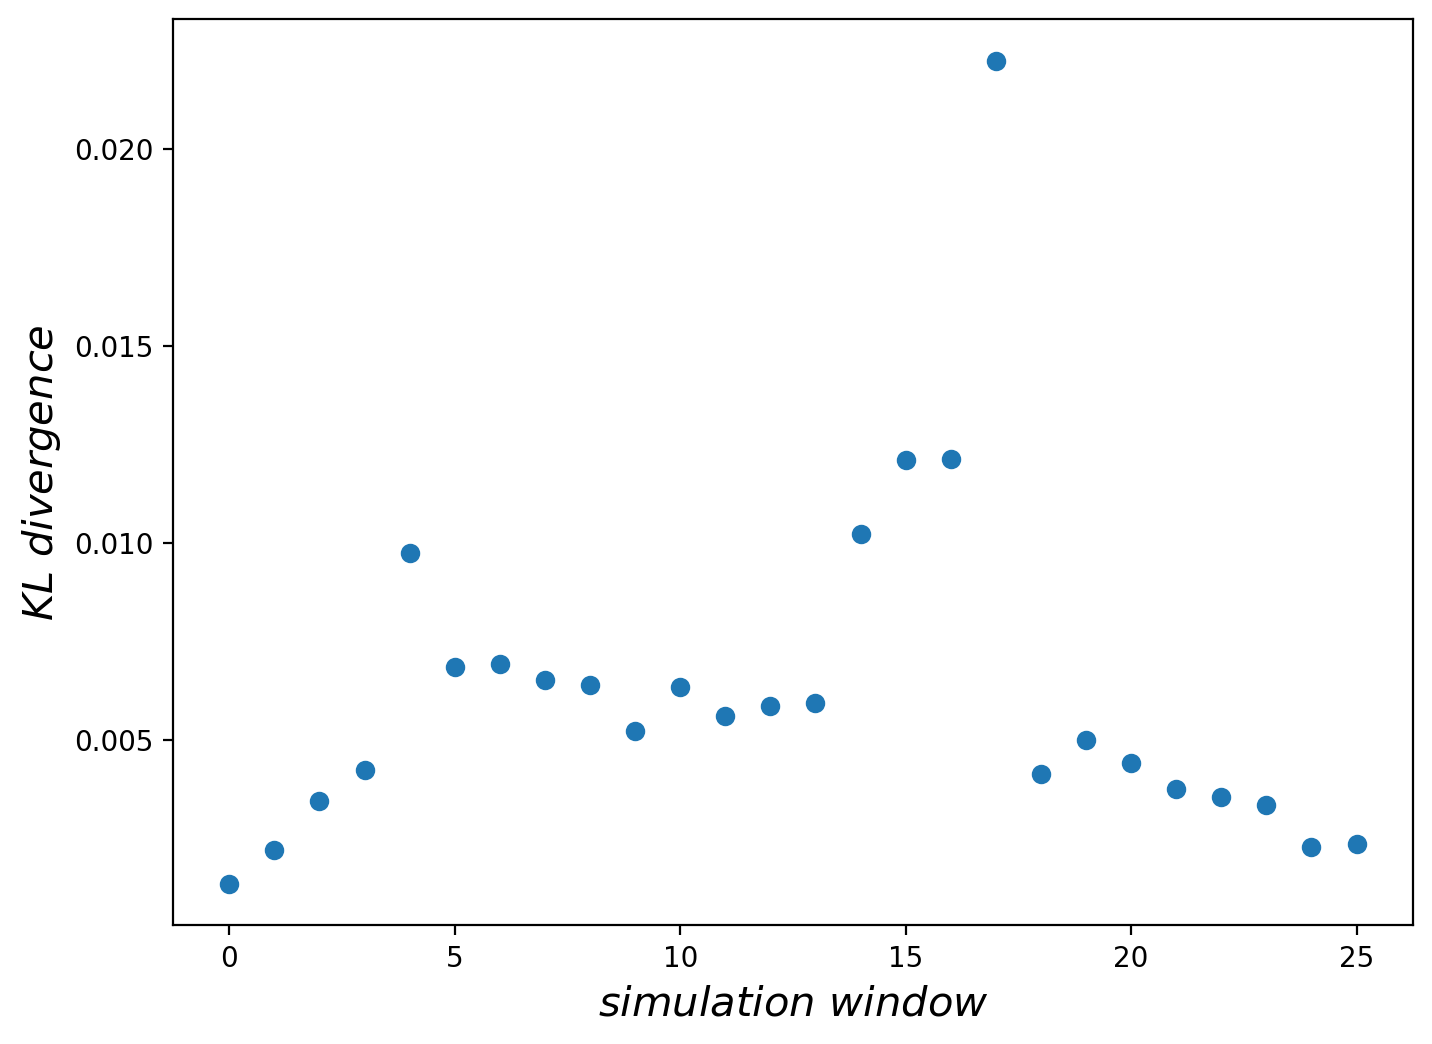

In [104]:
kl_divergence(cc)

Text(0, 0.5, '$\\beta F$')

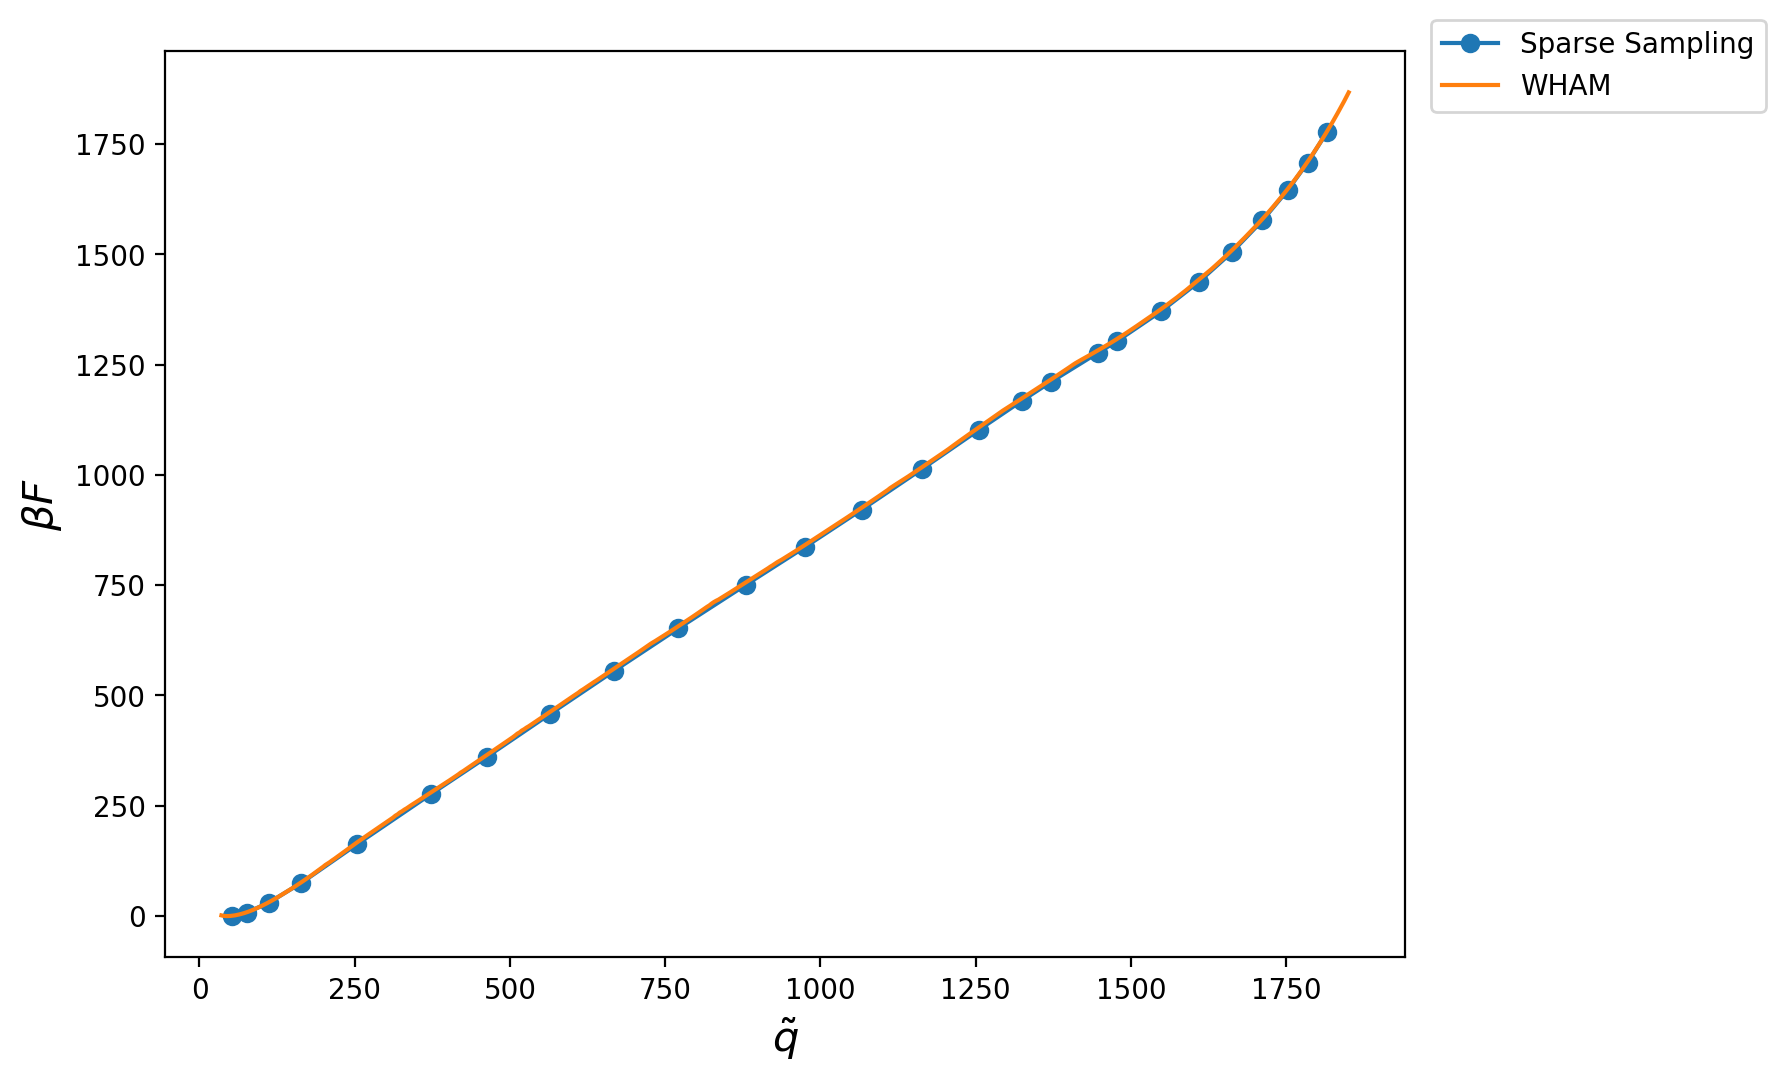

In [112]:
avg_q = aa.average_q
q_bins = cc.bins_
figure(figsize=(8,6), dpi=200)

plt.plot(avg_q, free_energyy, marker='o')
plt.plot(q_bins,F)
plt.legend(['Sparse Sampling', 'WHAM'], bbox_to_anchor=(1.01, 1.05))  
plt.xlabel(r'$\tilde{q}$', fontsize=15)
plt.ylabel(r'$\beta F$', fontsize=15)

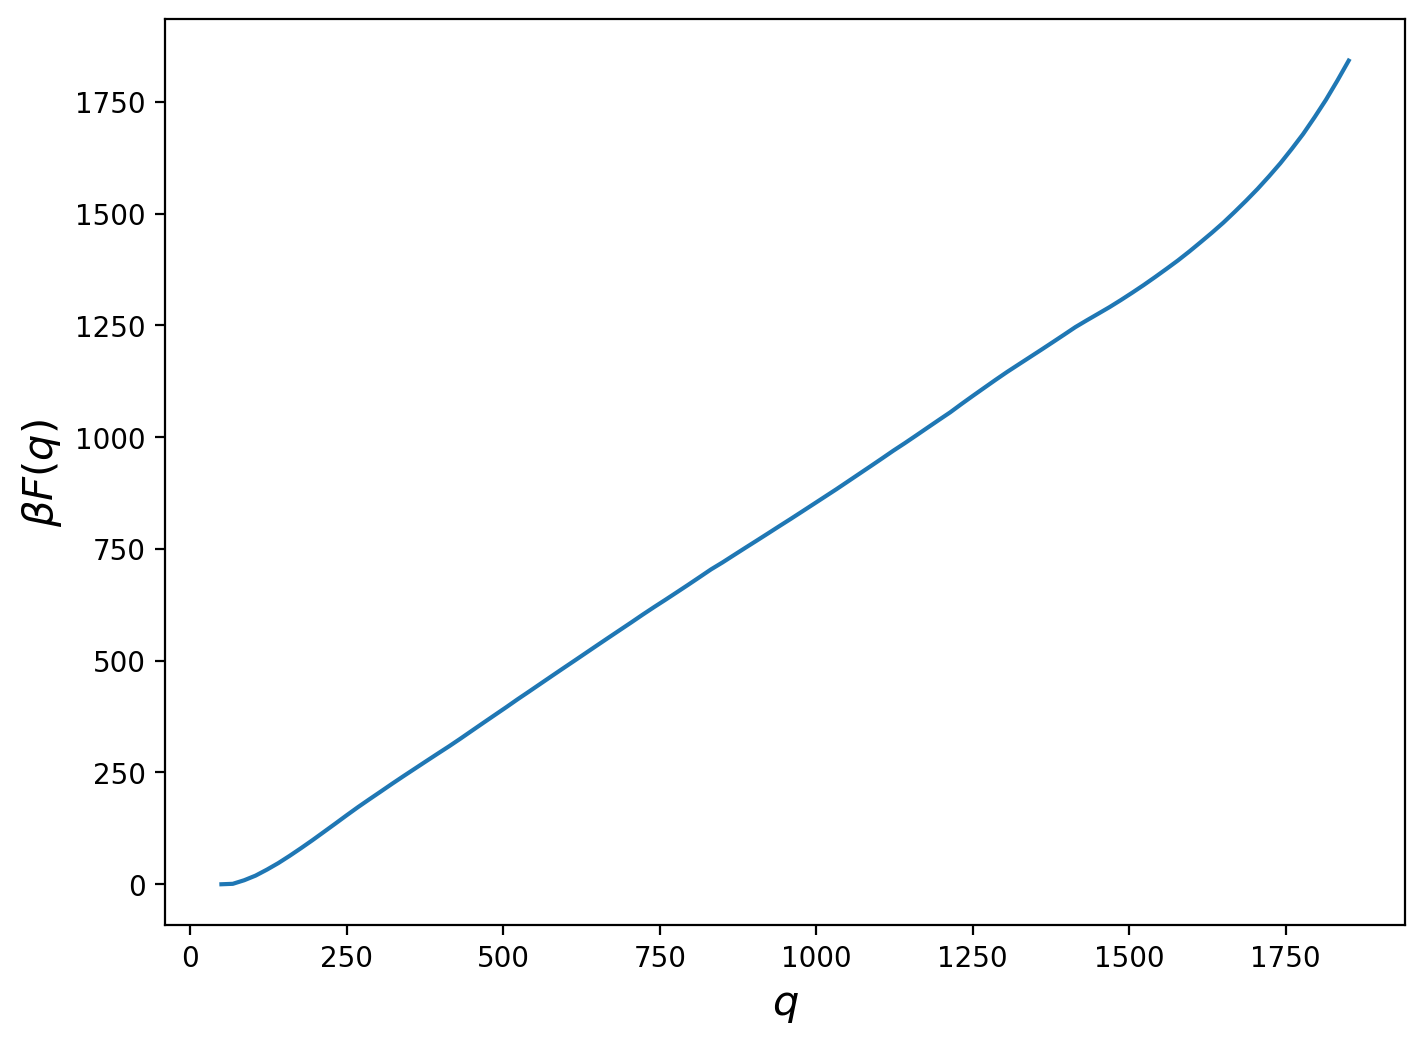

In [119]:
gi, log_pl, F = cc.MLE_optimize()

2.471293704805474


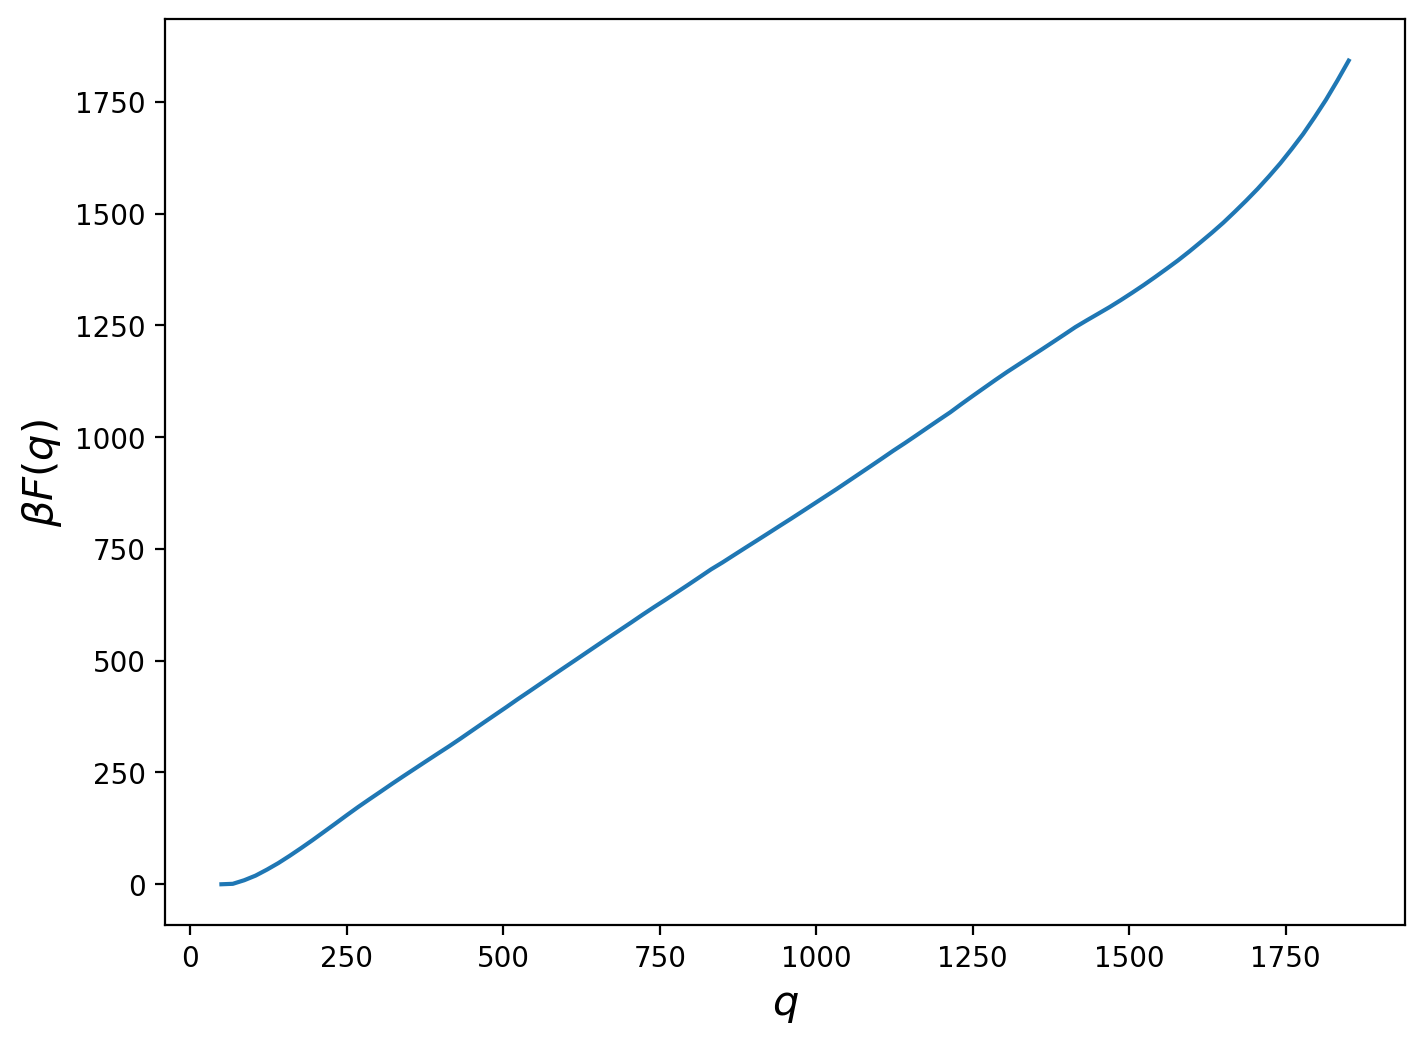

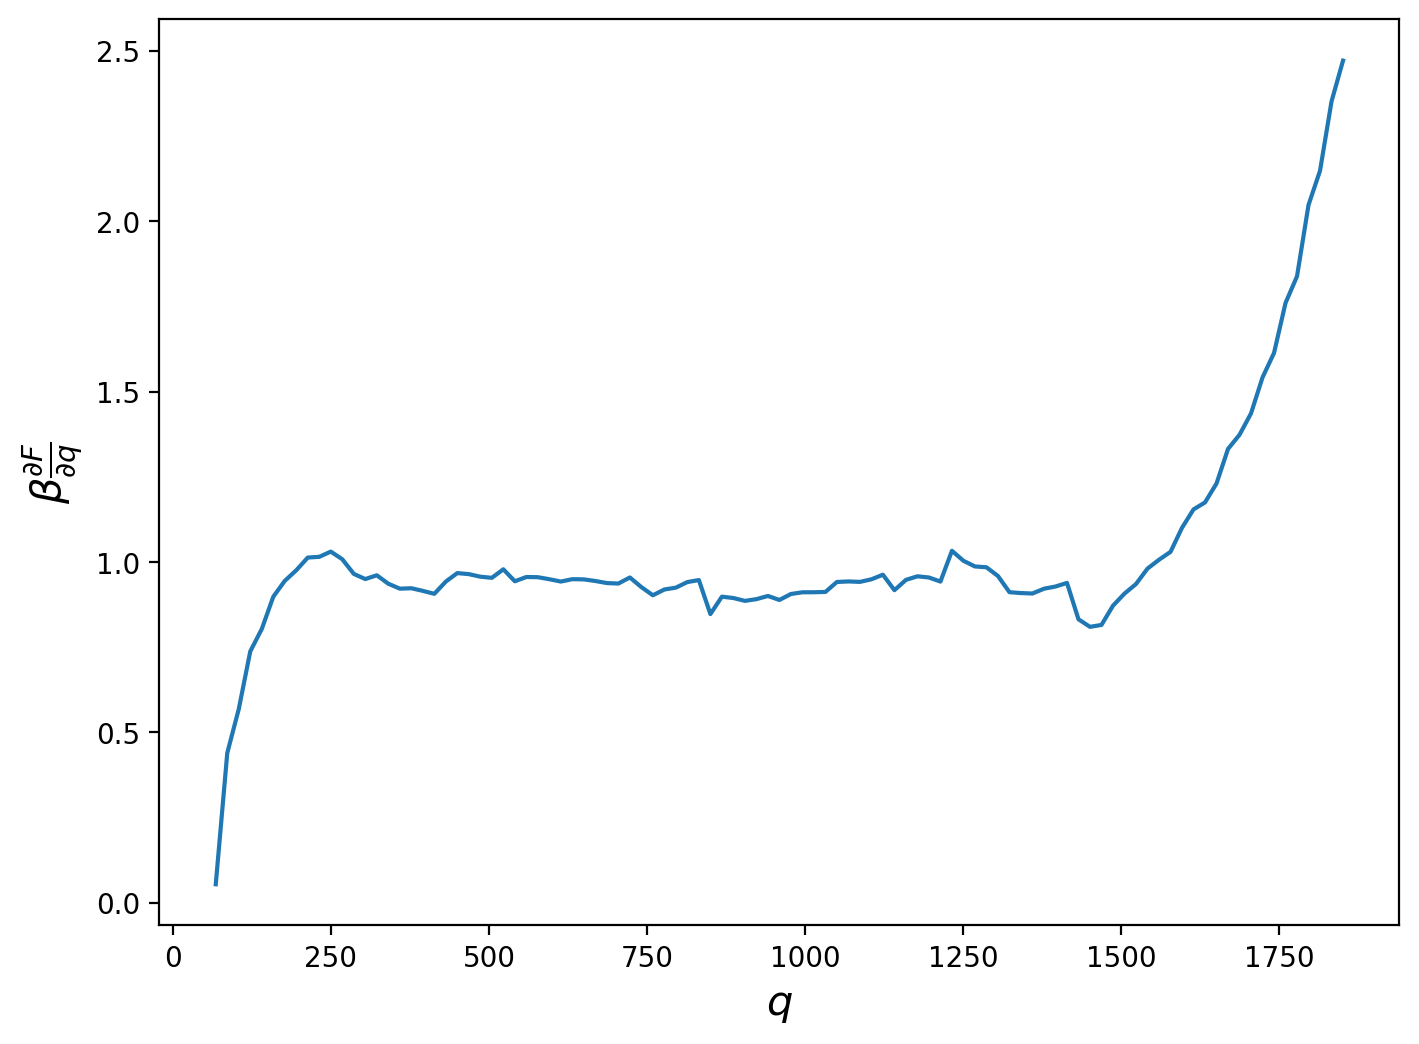

In [115]:
bins_df,dF = cc.driving_force()
print(max(dF))

sort_dF = np.sort(dF)

In [116]:
# This code is writting by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from matplotlib.pyplot import figure


class harm_to_phi:
    '''
    reweighting harmonic bias simulation to linear bias simulation
    
    Args:
    phi(numpy.ndarray): beta*phi values that I want to use (N,)
    q_wham(numpy.ndarray): order parameter value that obtained from harmonic bias simulation WHAM (M,)
    F(numpy.ndarray): Free energy value from harmonic bias simulation WHAM (M,)
    '''
    
    def __init__(self, phi, q_wham, F):
        np.errstate(divide='ignore')
        
        self.phi = phi
        self.q_wham = q_wham
        self.F = F
        self.prob_phi = np.zeros((len(self.phi), len(self.q_wham)),dtype=np.longdouble)
        self.log_prob_phi = np.zeros((len(self.phi), len(self.q_wham)),dtype=np.longdouble)
        
    def q_phi(self):
        np.errstate(divide='ignore')
        
        for i in range (self.prob_phi.shape[0]):
            #idea: numpy can calculate upto exp(700), make exp(max(function)) ~ exp(700)
            max_ = np.max(-self.F - self.q_wham*self.phi[i])
            diff = max_ - 700
            exp_term = np.exp(-self.F - self.q_wham*self.phi[i] -diff)
            self.prob_phi[i,:] = exp_term/np.sum(exp_term)
        
        self.q_phi = np.zeros(len(self.phi),)
        for i in range(self.prob_phi.shape[0]):
            self.q_phi[i] = np.sum(self.prob_phi[i,:]*self.q_wham)
        
        figure(figsize=(8,6), dpi = 200)
        plt.xlabel(r'$-\beta \phi$')
        plt.ylabel(r'$<q_v>_\phi$')
        plt.plot(-self.phi, self.q_phi)
        
        
        return self.phi, self.q_phi
    
    def suscept(self):
        np.errstate(divide='ignore')
        
        self.susceptt = np.zeros(len(self.phi) - 1)
        for i in range(len(self.phi) -1):
            self.susceptt[i] = - (self.q_phi[i+1] - self.q_phi[i])/ (self.phi[i+1] - self.phi[i])
        
        figure(figsize=(8,6), dpi=200)
        plt.plot(-self.phi[1:,], self.susceptt)
        plt.xlabel(r'$-\beta \phi$')
        plt.ylabel(r'$\chi_v$')
        
        phi_star = self.phi[np.argmax(self.susceptt) +1]
        
        return self.phi[1:], self.susceptt, phi_star

        

In [120]:
phi = np.linspace(0,-3.0,100)
q_wham = cc.bins_
F = F
aaa = harm_to_phi(phi, q_wham, F)

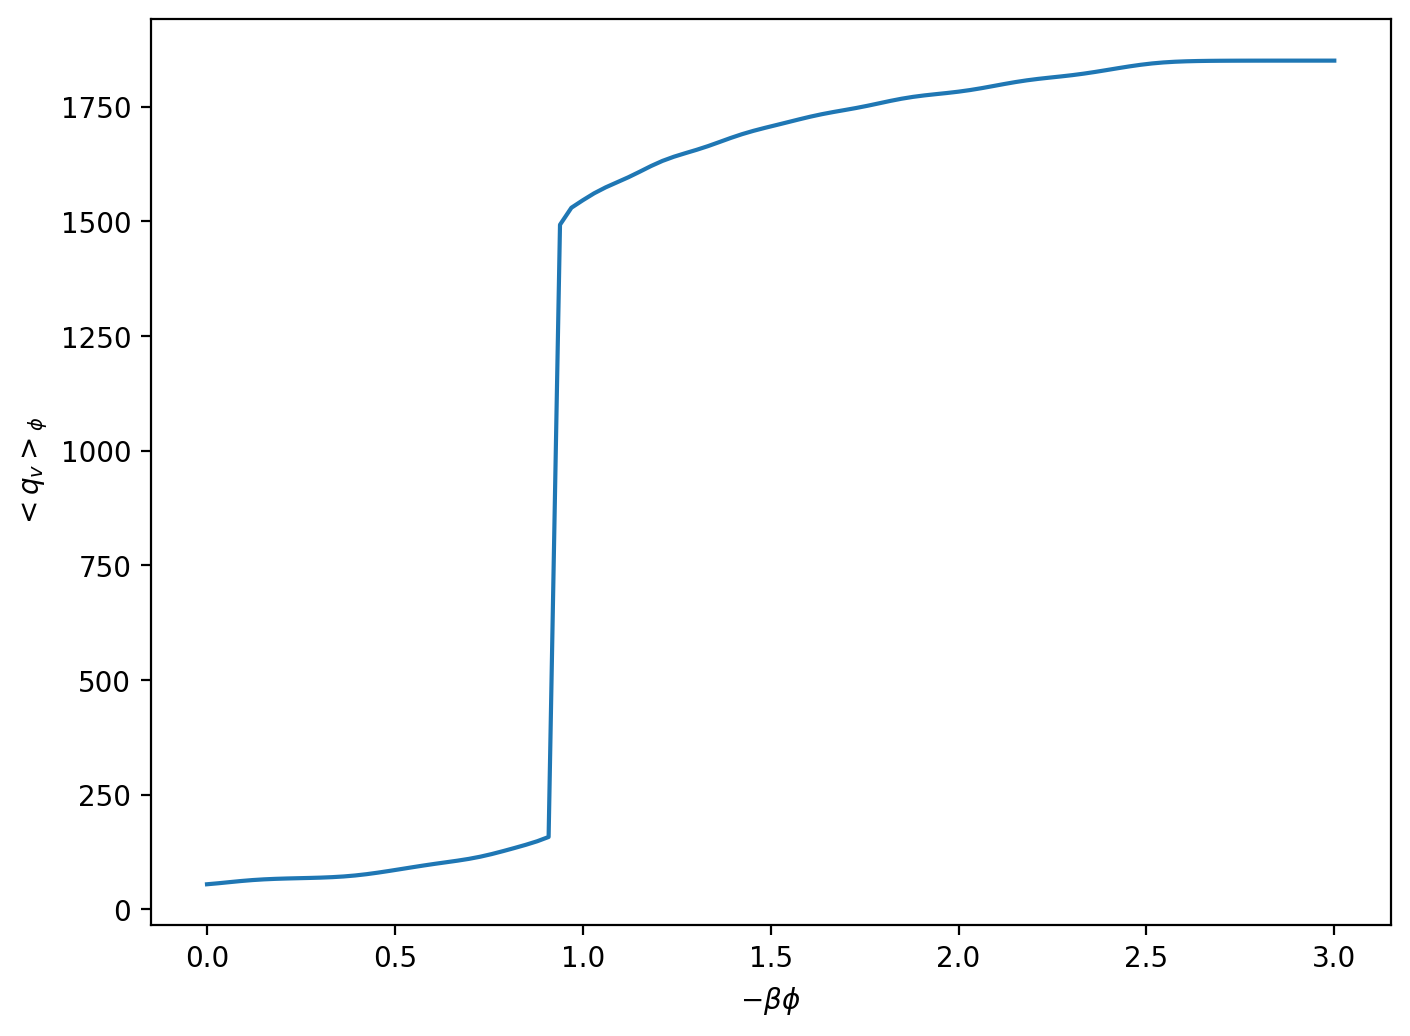

In [121]:
pp,q_pp = aaa.q_phi()

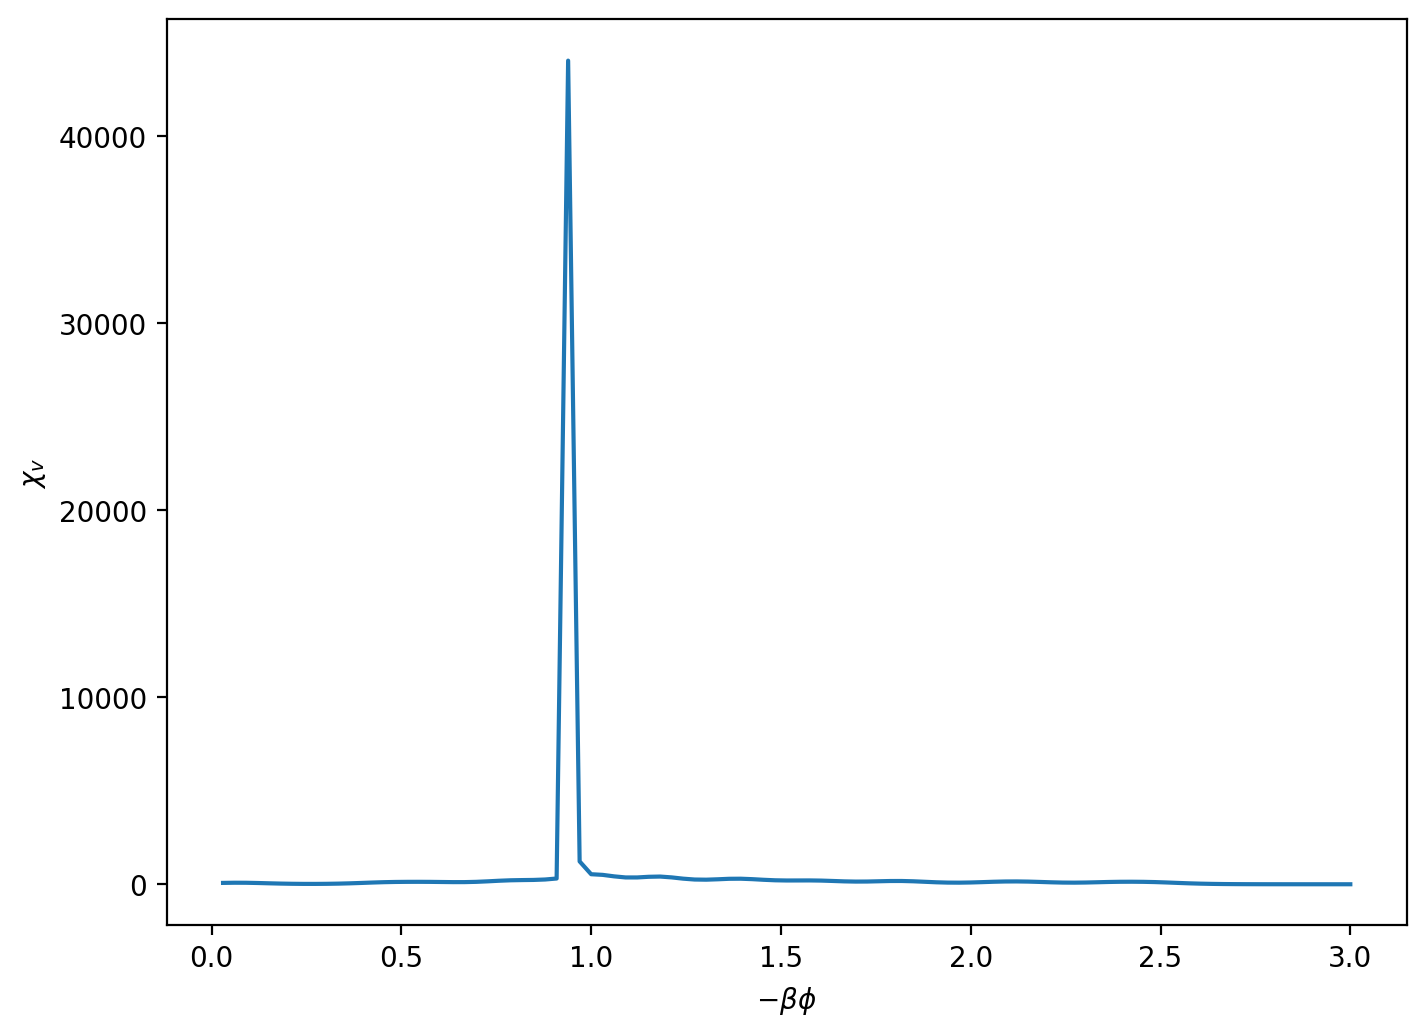

In [122]:
e, f, g = aaa.suscept()

In [107]:
# This code is writting by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

class sparse_sampling:
    '''
    Calculates free energy using sparse sampling
    
    Energy has three terms. 
    1. first energy: density probability of bias simulation
    2. second energy: applied harmonic potential 
    3. third energy: thermodynamic integration
    
    Args:
      q_star_arr(numpy.ndarray): q* matrix (N,)
      q_arr(numpy.ndarray): q matrix (simulation #, time #)
      n_bins(int): The number of bins that the probability should bin
      kappa(float): harmonic bias spring constant in kJ/mol
    '''
    
    
    def __init__(self, q_star_arr, q_arr, n_bins, kappa):
        
        self.q_star_arr = q_star_arr
        self.q_arr = q_arr
        self.n_bins = n_bins
        self.kappa = kappa
        
        #number of simulations
        self.n_simulation = q_arr.shape[0]
        
        #number of time frames for each simulation
        self.n_time = q_arr.shape[1]
        
        #average q value for each simulation
        self.average_q = []
        for i in range(self.n_simulation):
            self.average_q += [np.average(q_arr[i])]
        self.average_q = np.array(self.average_q)
        
    
    def first_energy(self, plot = True):
        
        '''
        Return:
           1. bins(numpy.ndarray): collection of bins for each simulation (simulation #, n_bins)
           2. prob(numpy.ndarray): collection of probability for each simulation (simulation #, n_bins)
           3. first_energy(numpy.ndarray): first energy for each simulation without unit(simulation #,)
        '''
        
        bins = []
        prob = []
        
        for i in range(self.n_simulation):
            q = self.q_arr[i]
            min_ = np.min(q)
            max_ = np.max(q)
            bins_ = np.linspace(min_, max_, self.n_bins)
            
            digitized = np.digitize(q, bins_, right = True)
            prob_ = (np.array([(digitized == i).sum() for i in range(0,self.n_bins)])+1)/ self.n_time
            
            bins += [bins_]
            prob += [prob_]
            
        bins = np.array(bins)
        prob = np.array(prob)
        
        first_energy = []
        for i in range(self.n_simulation):
            first_energy += [-np.log(np.max(prob[i]))]
        first_energy = np.array(first_energy)
        
        
        #make plot
        if plot:
            figure(figsize=(8, 6), dpi=200)

            for i in range(bins.shape[0]):
                plt.plot(bins[i], -np.log(prob[i]), marker = 'o')

            plt.legend(q_star_arr, bbox_to_anchor=(1.01, 1.05))    
            plt.xlabel(r'$\tilde{q}$', fontsize=15)
            plt.ylabel(r'$\beta F_v^{harm}(\tilde{q})$', fontsize=15)
        
        
        return bins, prob, first_energy
    
    
    
    def second_energy(self,temperature = 298, plot = True):
        
        '''
        Return:
           1. average_q(numpy.ndarray): average q value for each simulation (simulation #,)
           2. second_energy(numpy.ndarray): second energy term without unit (simulation #,)
        '''
        
        second_energy = []
        
        for i in range(self.n_simulation):
            q_diff = self.average_q[i] - np.float(self.q_star_arr[i])
            beta_T = 1/8.314/temperature*1000
            second_energy += [0.5*self.kappa*np.power(q_diff,2)*beta_T]
            
        second_energy = np.array(second_energy)
        
        #plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.average_q, second_energy, marker = 'o')
            plt.xlabel(r'$\tilde{q}$', fontsize=15)
            plt.ylabel(r'$\beta U_{v}^{harm}$', fontsize=15)
        
        return self.average_q, second_energy
    

    
    def third_energy(self,temperature = 298, plot = True):
        
        '''
        Return:
           1. q_star_arr(numpy.ndarray): q star value for each simulation (simulation #,)
           2. third_energy(numpy.ndarray): third energy term without unit (simulation #,)
        '''      
        
        
        #Calculate integrand
        dfdq_star=[]

        for i in range(self.n_simulation):
            q_diff = -(self.average_q[i]-np.float(self.q_star_arr[i]))
            beta_T = 1/8.314/temperature*1000
            dfdq_star+=[self.kappa*q_diff*beta_T]

        dfdq_star=np.array(dfdq_star)

        #make a plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.q_star_arr, dfdq_star, marker = 'o')
            plt.xlabel(r'$q*$', fontsize=15)
            plt.ylabel(r'$\beta \partial F_{q*}/ \partial q*$', fontsize=15)
        
        
        
        #Get integral
        #make the first term 0. Note that it is integral. I should have reference value, in this case the value would be 0
        third_energy=[]
        third_energy+=[0]
        for i in range(self.n_simulation -1):
            third_energy += [(np.float(self.q_star_arr[i+1]) - np.float(self.q_star_arr[i]))*(dfdq_star[i+1] + dfdq_star[i])/2 + np.float(third_energy[i])]
        third_energy=np.array(third_energy)

        #make a plot
        if plot:
            figure(figsize=(8, 6), dpi=200)
            plt.plot(self.q_star_arr, third_energy, marker = 'o')
            plt.xlabel(r'$q*$', fontsize=15)
            plt.ylabel(r'$\beta F_{harm} (q*)$', fontsize=15)
        
        return self.q_star_arr, third_energy
    
    
    def free_energy(self, temperature = 298, plot = False):
        
        '''
        Return:
           1. q_star_arr(numpy.ndarray): q star value for each simulation (simulation #,)
           2. free_energy(numpy.ndarray): free energy term without unit (simulation #,)
           3. driving_force(numpy.ndarray): driving force term without unit (simulation # -1,)
        '''      
        
        _, _, first = self.first_energy(plot)
        _, second = self.second_energy(temperature, plot)
        _, third = self.third_energy(temperature, plot)
        
        figure(figsize=(8, 6), dpi=200)
        free_energy = first - second + third
        min_e = np.min(free_energy)
        #set starting free energy as 0
        free_energy = free_energy - min_e
        
        figure(figsize=(8, 6), dpi=200)
        plt.plot(self.average_q, free_energy, marker = 'o')
        plt.xlabel(r'$\tilde {q}$', fontsize=15)
        plt.ylabel(r'$\beta F_{v} (\tilde {q})$', fontsize=15)
        
        
        #Get driving force by differentiating the free energy
        diff_average_q = np.array([self.average_q[i+1]- self.average_q[i] for i in range(np.shape(self.average_q)[0]-1)])
        diff_energy = np.array([free_energy[i+1]- free_energy[i] for i in range(np.shape(self.average_q)[0]-1)])
        driving_force = diff_energy/diff_average_q

        figure(figsize=(8, 6), dpi=200)
        plt.plot(self.average_q[:-1], driving_force, marker = 'o')
        plt.xlabel(r'$\tilde {q}$', fontsize=15)
        plt.ylabel(r'$\beta \partial F_{v}/\partial \tilde {q}$', fontsize=15)
        
        
        
        return self.q_arr, free_energy, driving_force

In [108]:
aa = sparse_sampling(q_star_arr, q_arr, 50, 0.01)

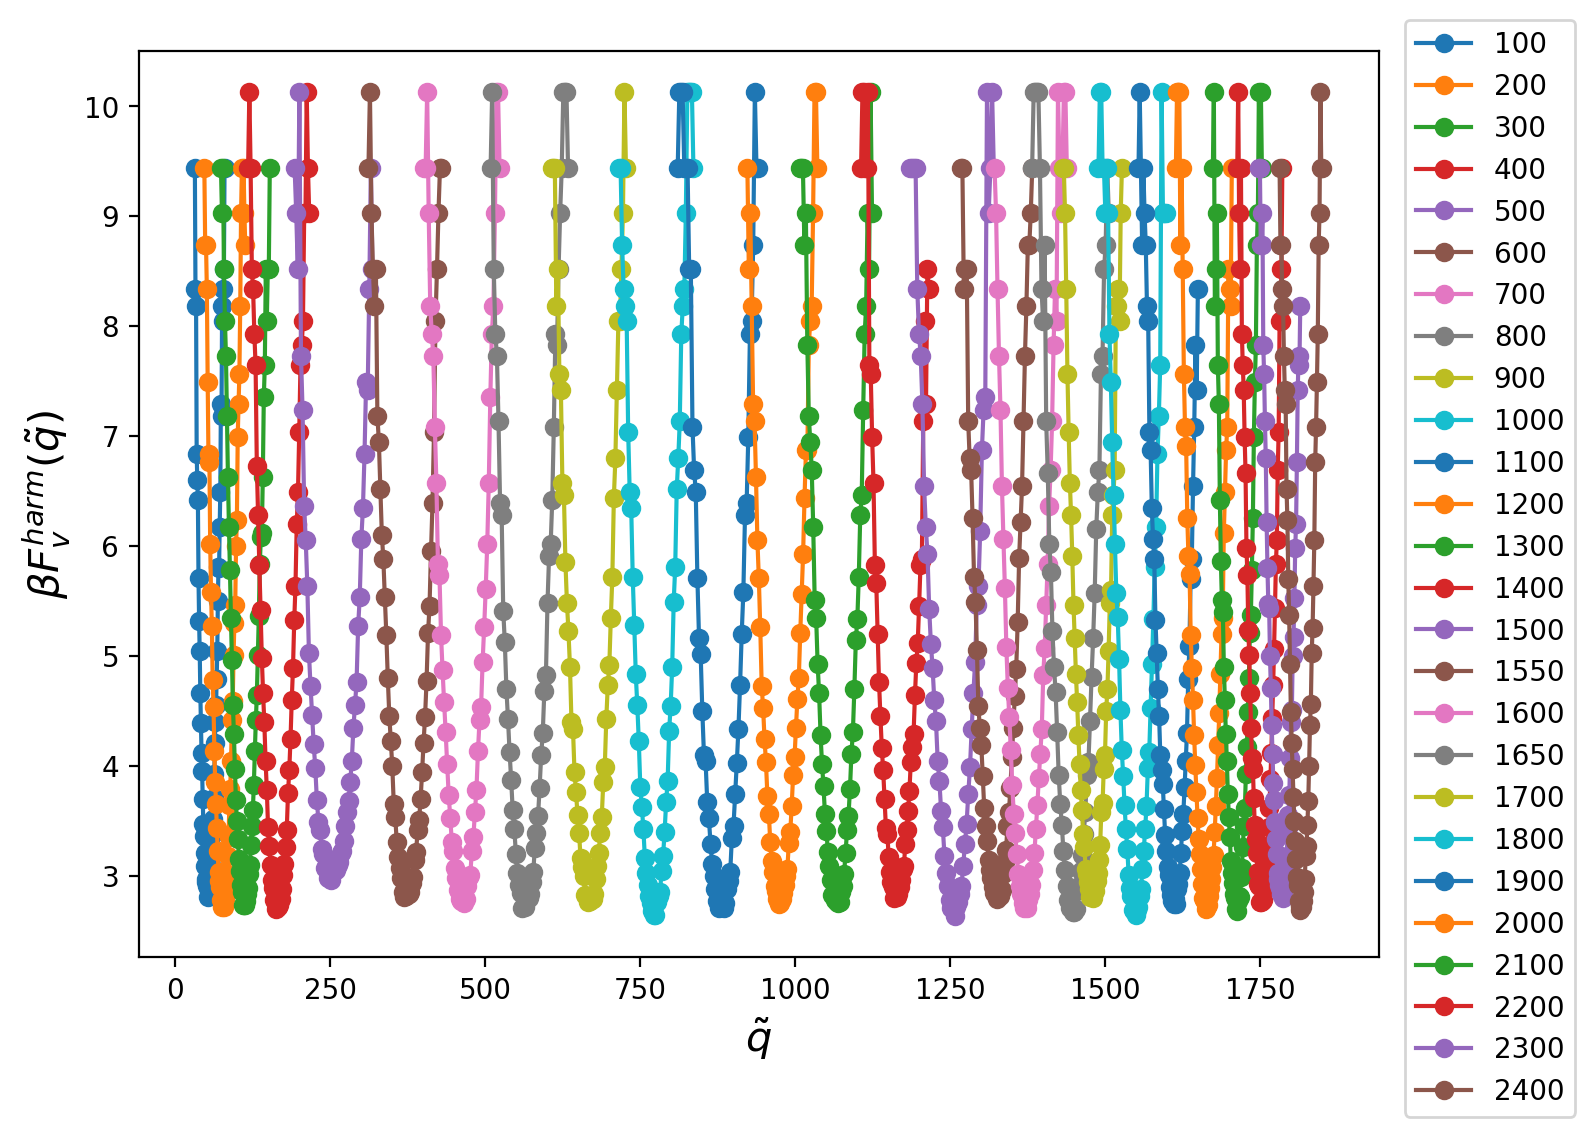

In [109]:
pro, binss, first_e = aa.first_energy()

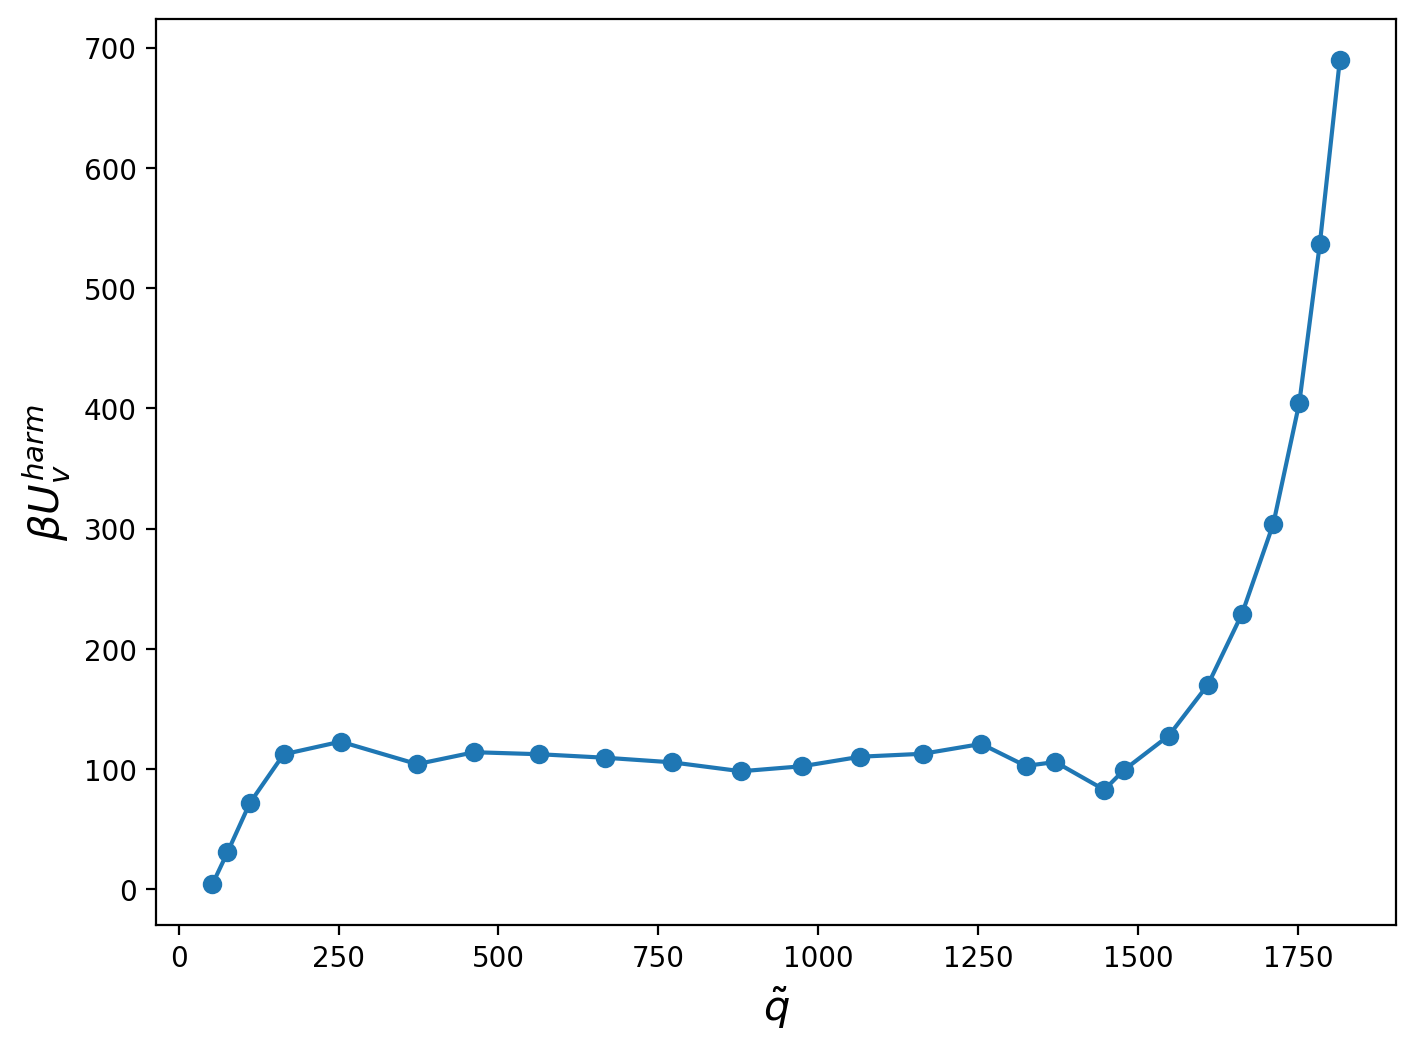

In [110]:
q_arrrr, second_energy = aa.second_energy()

<Figure size 1600x1200 with 0 Axes>

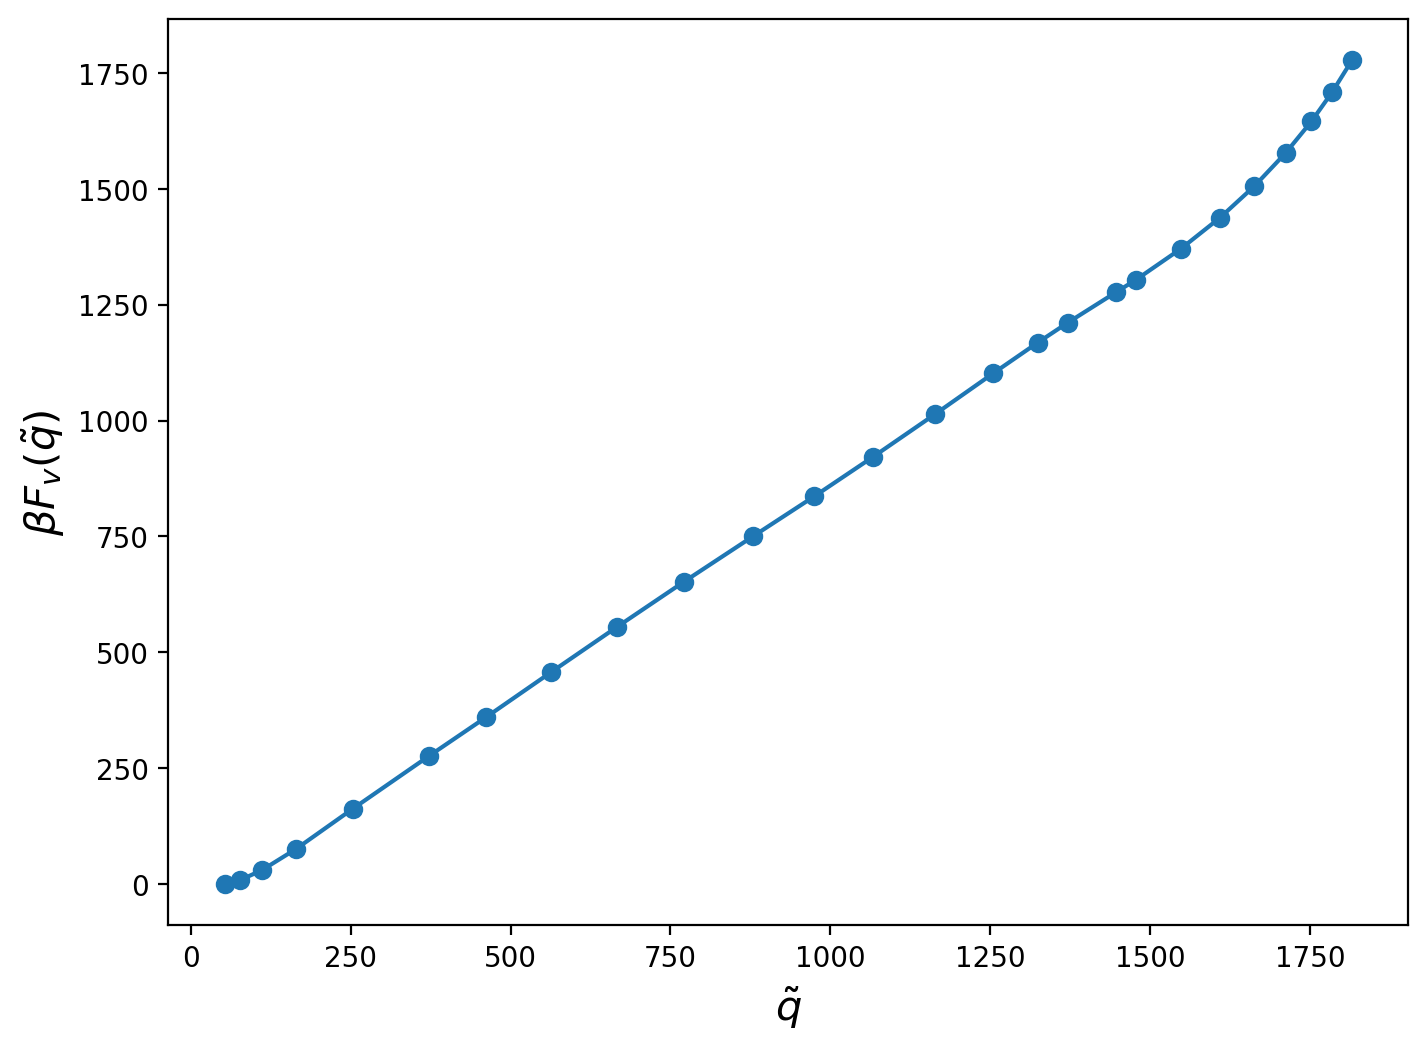

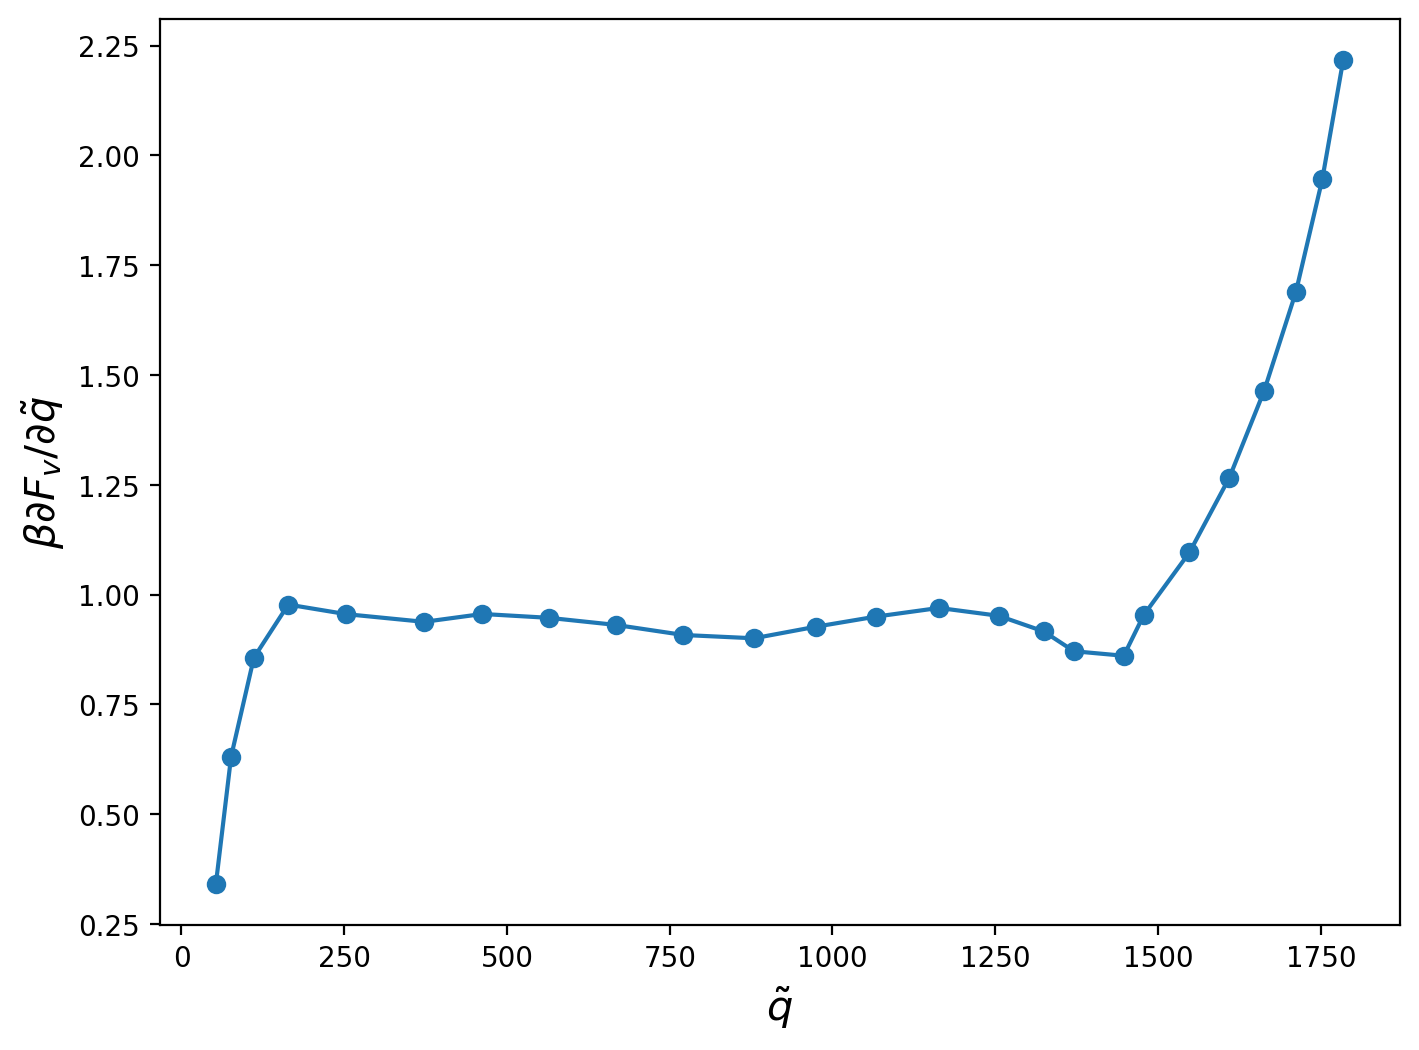

In [111]:
q_arrr, free_energyy, driving_forcee = aa.free_energy()

Text(0, 0.5, '$-\\beta\\phi$')

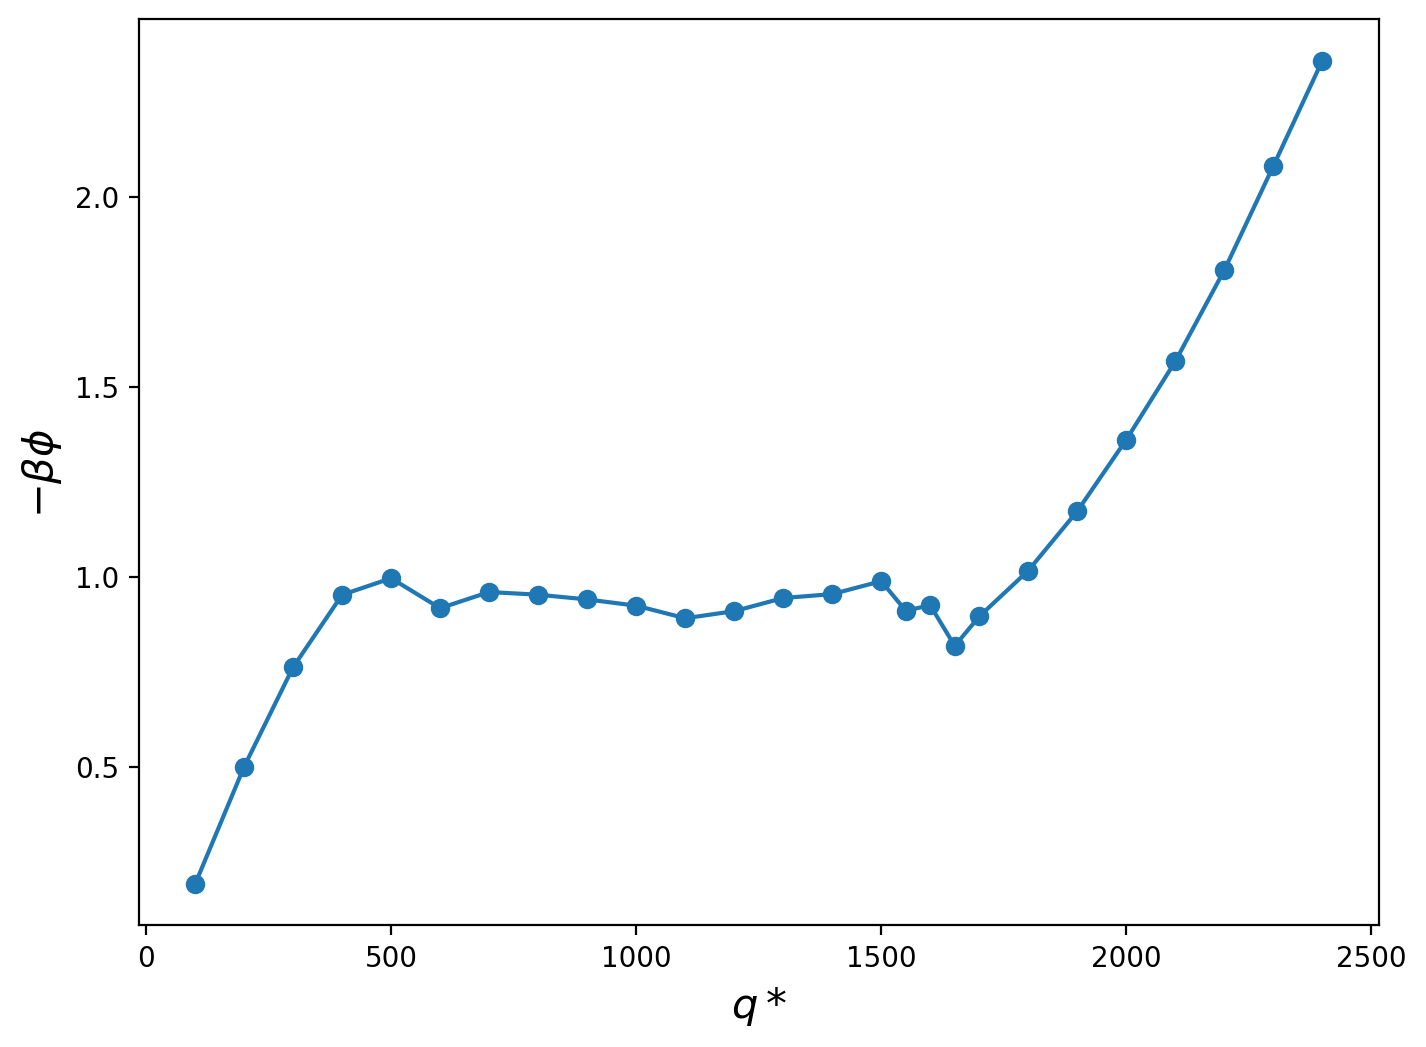

In [60]:
from matplotlib.pyplot import figure
reweighted_phi = beta*0.01*(avg_q - q_star_arr2)


figure(figsize=(8, 6), dpi=200)

plt.plot(q_star_arr2, -reweighted_phi, marker = 'o')

   
plt.xlabel(r'$q*$', fontsize=15)
plt.ylabel(r'$-\beta\phi$', fontsize=15)

In [61]:
rreweighted_phi = np.zeros(len(q_star_arr2),)
rreweighted_phi[0] = -reweighted_phi[0]

for i in range(1,len(q_star_arr2)):
    negative_reweighted = - reweighted_phi
    maxx = np.max(negative_reweighted[:i])
    rreweighted_phi[i] = -maxx

Text(0, 0.5, '$-\\beta\\phi$')

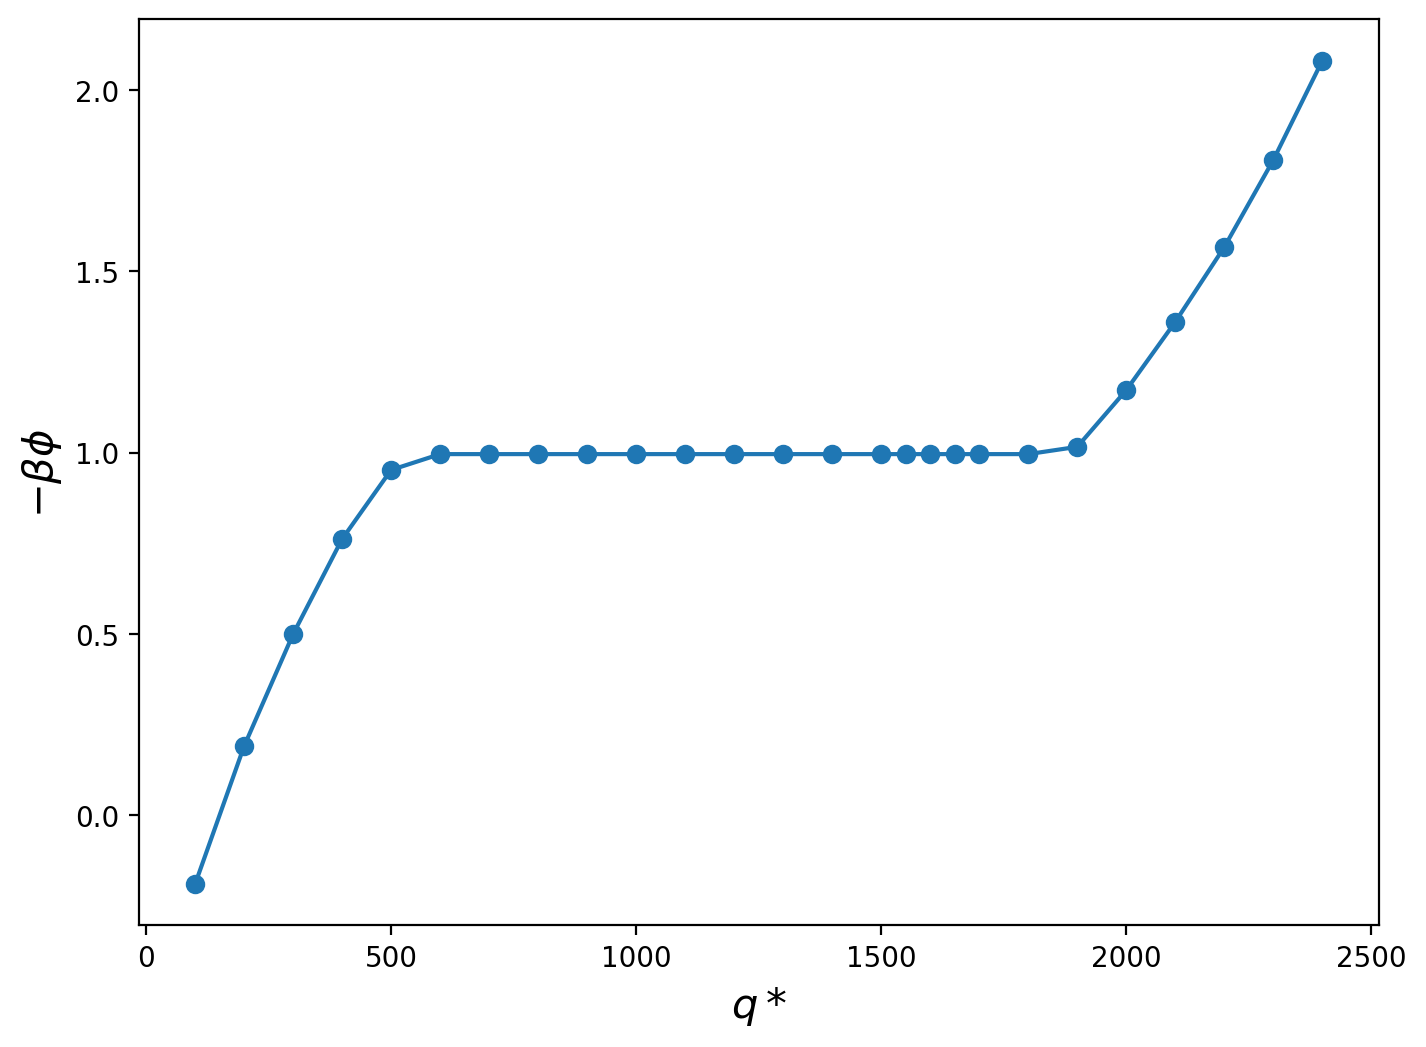

In [62]:
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=200)

plt.plot(q_star_arr2, -rreweighted_phi, marker = 'o')

   
plt.xlabel(r'$q*$', fontsize=15)
plt.ylabel(r'$-\beta\phi$', fontsize=15)

In [80]:
q_star_arr2

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1550, 1600, 1650, 1700, 1800, 1900, 2000,
       2100, 2200, 2300, 2400])

In [81]:
q_arr.shape

(26, 25001)